### Project 2 : Porto Seguro’s Safe Driver Prediction——Mengyan Zhu

### 1. Data preparation

#### 1.1 Load Data

In [283]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [226]:
#load data
train=pd.read_csv('input/train.csv')
test=pd.read_csv('input/test.csv')
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [99]:
# Have a look at all variables in train dataset
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


#### 1.2 Check missing value

In [101]:
#check missing values
train_c= train
train_c = train_c.replace(-1, np.NaN)
np.isnan(train_c).any().any()

True

In [103]:
# Get the percentage of missing value in each variables
col_nan = train_c.columns[train_c.isnull().any()]
print("The percentage of missing values in each column is:")
for i in col_nan:
    print(i, '{:.2f}%'.format(train_c[i].isnull().sum()/len(train.target)*100))

The percentage of missing values in each column is:
ps_ind_02_cat 0.04%
ps_ind_04_cat 0.01%
ps_ind_05_cat 0.98%
ps_reg_03 18.11%
ps_car_01_cat 0.02%
ps_car_02_cat 0.00%
ps_car_03_cat 69.09%
ps_car_05_cat 44.78%
ps_car_07_cat 1.93%
ps_car_09_cat 0.10%
ps_car_11 0.00%
ps_car_12 0.00%
ps_car_14 7.16%


#### 1.3 Data visualization

3.64% people fill a claim


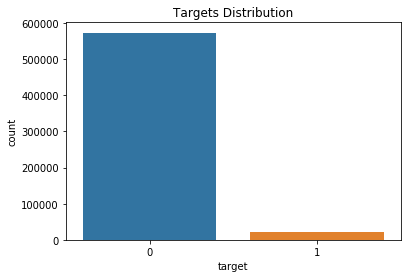

In [104]:
# Target Distribution
sns.countplot(x="target", data=train)
plt.title('Targets Distribution')
print ('{:.2f}%'.format(len(train[train['target']==1])/len(train.target)*100)+" people fill a claim")

In [3]:
# classify data into three groups: categorical,binary and continuous
col_cat = [column for column in train.columns if '_cat' in column]
print("number of categorical feature : ", len(col_cat))

col_bin = [column for column in train.columns if '_bin' in column]
print("number of binary feature : ", len(col_bin))

col_cont=train.columns.drop(['target', 'id'])
col_cont=col_cont.drop(col_cat)
col_cont=col_cont.drop(col_bin)
print("number of continuous feature : ", len(col_cont))

number of categorical feature :  14
number of binary feature :  17
number of continuous feature :  26


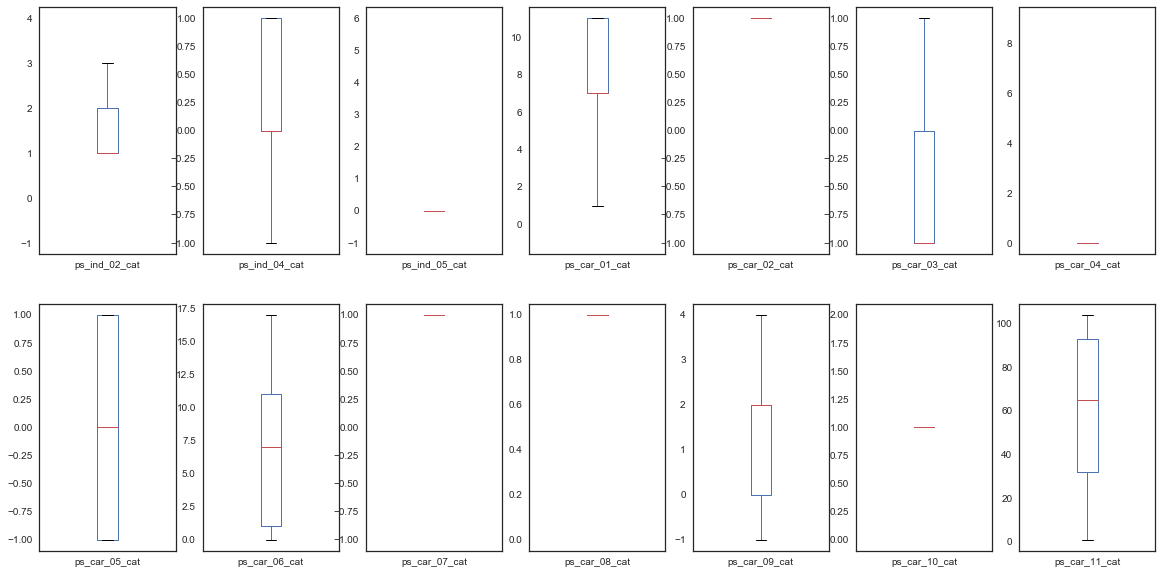

In [115]:
# Distribution of categorical features
train[col_cat].plot(kind='box', subplots=True, layout=(2,7), sharey=False, figsize=(20,10))
plt.show()

Text(0.5,1,'Correlation of Categorical Feature')

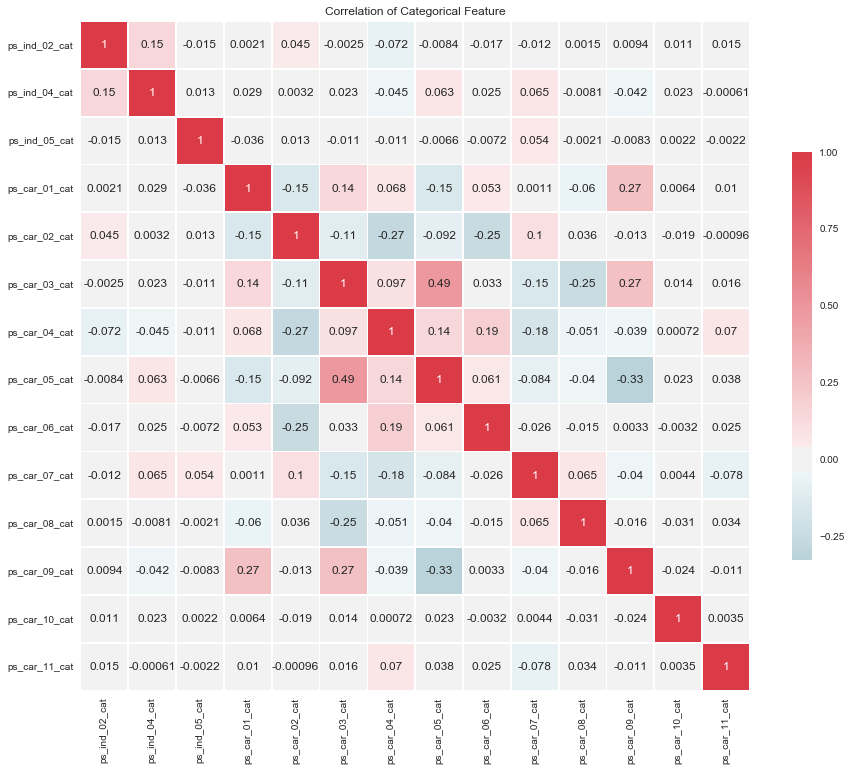

In [121]:
#Correlation of Categorical Feature
sns.set(style="white")
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train[col_cat].corr(), cmap=cmap, vmax=1, center=0,square=True, linewidths=.8, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation of Categorical Feature')

In [114]:
#Statistics description of binary features
train[col_bin].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5,1,'Correlation of Continuous Features')

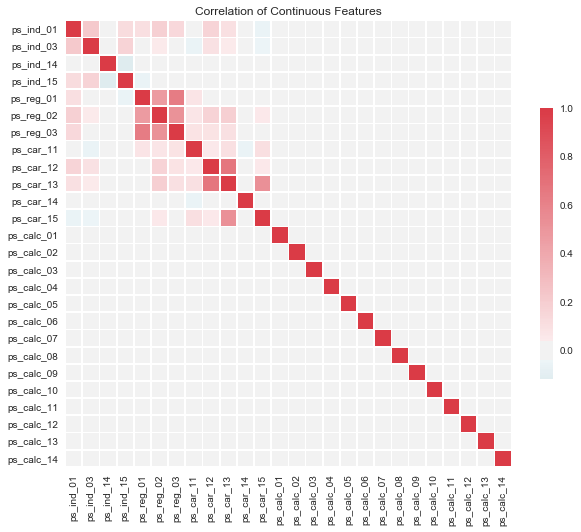

In [113]:
#Correlation of Continuous Features
sns.set(style="white")
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train[col_cont].corr(), cmap=cmap, vmax=1, center=0,square=True, linewidths=.8, cbar_kws={"shrink": .5})
plt.title('Correlation of Continuous Features')

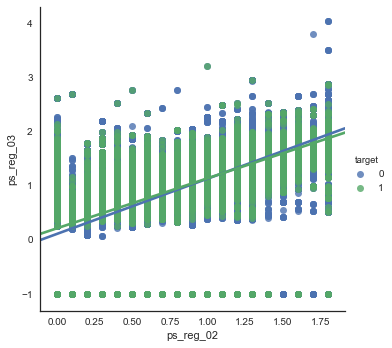

In [117]:
# relationship between ps_reg_02' and 'ps_reg_03
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=train, hue='target')

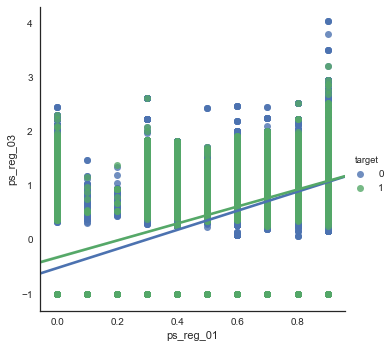

In [118]:
# relationship between ps_reg_01' and 'ps_reg_03
sns.lmplot(x='ps_reg_01', y='ps_reg_03', data=train, hue='target')

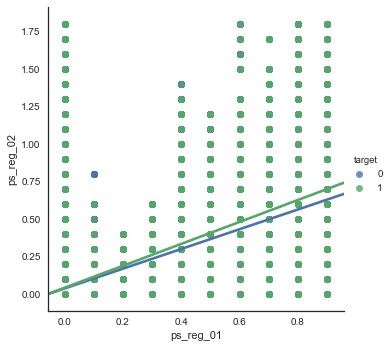

In [119]:
# relationship between ps_reg_01' and 'ps_reg_02
sns.lmplot(x='ps_reg_01', y='ps_reg_02', data=train, hue='target')

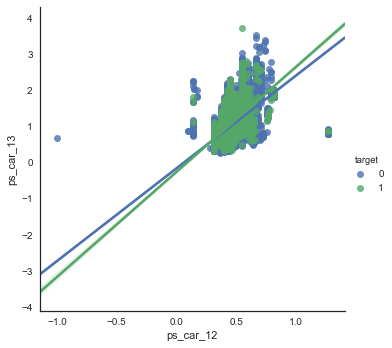

In [120]:
# relationship between ps_car_12 and ps_car_13
sns.lmplot(x='ps_car_12', y='ps_car_13', data=train, hue='target')

Text(0.5,1,'Correlation of All Variables')

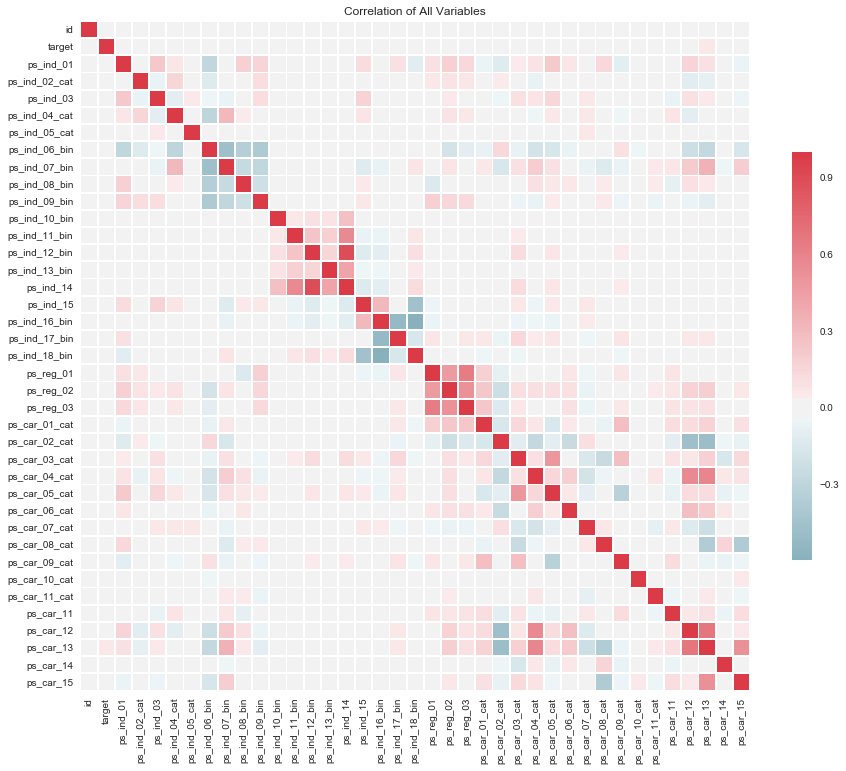

In [193]:
#Correlation of all features
sns.set(style="white")
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train.corr(), cmap=cmap, vmax=1, center=0,square=True, linewidths=.8, cbar_kws={"shrink": .5})
plt.title('Correlation of All Variables')

### 2. Build baseline model

#### 2.1 Feature importance

In [270]:
# use logit to get significant features
col_feature=train.columns[2:]
import statsmodels.api as sm
logit=sm.Logit(train['target'],train[col_feature])
result=logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.153038
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               595212
Model:                          Logit   Df Residuals:                   595156
Method:                           MLE   Df Model:                           55
Date:                Thu, 14 Dec 2017   Pseudo R-squ.:                 0.02203
Time:                        20:05:24   Log-Likelihood:                -91090.
converged:                       True   LL-Null:                       -93142.
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ps_ind_01          0.0141      0.004      3.666      0.000       0.007       0.022
ps_ind_02_cat    

C:\Users\zmy\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\zmy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\zmy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\zmy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


#### 2.2 Relevance of Features

In [271]:
# First generate accuracy by using all values
input_all = train[col_feature].values

In [272]:
train0_X, test0_X, train0_y, test0_y = train_test_split(input_all, y, train_size=0.8,test_size=0.2,random_state=100)
base0= LogisticRegression()
base0.fit(train0_X, train0_y)
roc_train0_base= roc_auc_score(train0_y, base0.predict_proba(train0_X)[:,1])
roc_test0_base = roc_auc_score(test0_y, base0.predict_proba(test0_X)[:,1])
print(roc_train0_base, roc_test0_base)

0.624822651129 0.616946774333


In [235]:
# select all the significant features
input1 = pd.concat([train[["ps_ind_01","ps_ind_02_cat","ps_ind_03","ps_ind_04_cat","ps_ind_05_cat","ps_ind_06_bin",
                          "ps_ind_07_bin","ps_ind_08_bin","ps_ind_09_bin","ps_ind_16_bin","ps_ind_17_bin",
                           "ps_ind_15","ps_reg_01","ps_reg_02","ps_reg_03",
                          "ps_car_03_cat","ps_car_07_cat","ps_car_11","ps_car_12","ps_car_13","ps_car_15"]]], axis=1)

In [239]:
train1_X, test1_X, train1_y, test1_y = train_test_split(input1, y, train_size=0.8, test_size=0.2,random_state=100)
base1 = LogisticRegression()
base1.fit(train1_X, train1_y)
roc_train1_base= roc_auc_score(train1_y, base1.predict_proba(train1_X)[:,1])
roc_test1_base = roc_auc_score(test1_y, base1.predict_proba(test1_X)[:,1])
print(roc_train1_base, roc_test1_base)

0.624283884545 0.617768544975


In [251]:
#select only one features if 2 or 3 features are correlated
input2 = pd.concat([train[["ps_ind_01","ps_ind_02_cat","ps_ind_03","ps_ind_04_cat","ps_ind_05_cat","ps_ind_06_bin",
                          "ps_ind_07_bin","ps_ind_08_bin","ps_ind_09_bin","ps_ind_16_bin","ps_ind_17_bin",
                           "ps_ind_15","ps_reg_03","ps_car_03_cat","ps_car_07_cat","ps_car_11","ps_car_13"]]], axis=1)

In [252]:
train2_X, test2_X, train2_y, test2_y = train_test_split(input2, y, train_size=0.8,test_size=0.2,random_state=100)
base2 = LogisticRegression()
base2.fit(train2_X, train2_y)
roc_train2_base= roc_auc_score(train2_y, base2.predict_proba(train2_X)[:,1])
roc_test2_base = roc_auc_score(test2_y, base2.predict_proba(test2_X)[:,1])
print(roc_train2_base, roc_test2_base)

0.622027357839 0.615919397152


In [260]:
# This time, drop the features with low variance
input3 = pd.concat([train[["ps_ind_01","ps_ind_02_cat","ps_ind_03","ps_ind_04_cat","ps_ind_06_bin",
                          "ps_ind_07_bin","ps_ind_08_bin","ps_ind_16_bin","ps_ind_17_bin",
                           "ps_ind_15","ps_reg_01","ps_reg_02","ps_reg_03","ps_car_03_cat","ps_car_11",
                           "ps_car_12","ps_car_13","ps_car_15"]]], axis=1)

In [261]:
train3_X, test3_X, train3_y, test3_y = train_test_split(input3, y, train_size=0.8,test_size=0.2,random_state=100)
base3= LogisticRegression()
base3.fit(train3_X, train3_y)
roc_train3_base= roc_auc_score(train3_y, base3.predict_proba(train3_X)[:,1])
roc_test3_base = roc_auc_score(test3_y, base3.predict_proba(test3_X)[:,1])
print(roc_train3_base, roc_test3_base)

0.613441655672 0.609735630905


### 3. Modeling

#### 3.1 Deal with missing values

In [4]:
# Deal with missing values
# Replace missing values with mode or median
def df_fillna(dataframe):
    df_na= dataframe.replace(-1, np.NaN)
    for column in df_na:
        if '_cat' in column or '_bin' in column:
            df_na[column].fillna(dataframe[column].mode()[0], inplace=True)
        else:
            df_na[column].fillna(dataframe[column].median(), inplace=True)
    return dataframe

In [5]:
# Check the result
train_na=df_fillna(train)
test_na=df_fillna(test)
print('Is there any missing value in train dataset?',np.isnan(train_na).any().any())
print('Is there any missing value in test dataset?',np.isnan(test_na).any().any())

Is there any missing value in train dataset? False
Is there any missing value in test dataset? False


#### 3.2 Generate X and Y

In [279]:
#Define X and y that used to train the model
X = pd.concat([train_na[["ps_ind_01","ps_ind_02_cat","ps_ind_03","ps_ind_04_cat","ps_ind_05_cat","ps_ind_06_bin",
                          "ps_ind_07_bin","ps_ind_08_bin","ps_ind_09_bin","ps_ind_16_bin","ps_ind_17_bin",
                           "ps_ind_15","ps_reg_01","ps_reg_02","ps_reg_03",
                          "ps_car_03_cat","ps_car_07_cat","ps_car_11","ps_car_12","ps_car_13","ps_car_15"]]], axis=1)
y = train_na.target.values

In [280]:
# Define X_test used to make prediction
X_test = pd.concat([test_na[["ps_ind_01","ps_ind_02_cat","ps_ind_03","ps_ind_04_cat","ps_ind_05_cat","ps_ind_06_bin",
                          "ps_ind_07_bin","ps_ind_08_bin","ps_ind_09_bin","ps_ind_16_bin","ps_ind_17_bin",
                           "ps_ind_15","ps_reg_01","ps_reg_02","ps_reg_03",
                          "ps_car_03_cat","ps_car_07_cat","ps_car_11","ps_car_12","ps_car_13","ps_car_15"]]], axis=1)

#### 3.3 Define Gini coefficient

In [45]:
# Define gini score
# This code is from https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    
    # If the predictions y_pred are binary class probabilities
    if y_pred.ndim == 2:
        if y_pred.shape[1] == 2:
            y_pred = y_pred[:, 1]
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

In [273]:
# Since input 1 is the most relevant input, choose base1 as baseline model
# Calculate gini coefficient
print ('Score of train:', gini_normalized(train1_y,base1.predict_proba(train1_X)[:,1]))
print ('Score of test:', gini_normalized(test1_y,base1.predict_proba(test1_X)[:,1]))

Score of train: 0.24856776909
Score of test: 0.235537089949


In [282]:
pred_base= base1.predict_proba(X_test)[:,1]
submit0 = pd.DataFrame({'id':test['id'],'target':pred_base})
submit0.to_csv('baseline.csv',index=False)

#### 3.4 Split the data

In [36]:
# Use StratifiedShuffleSplit to split data
kfold=5
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.2, random_state=100)
for train_index,test_index in sss.split(X,y):  
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

#### 3.5 Training and tuning the model

In [41]:
# Here begin train the model
# I want to compare the accuary of the model when I use predict and predict_proba 
# I use roc_auc_score and gini coefficient to evaluate the outcome 

#### 3.5.1 LogisticRegression()

In [77]:
# Compare the result to baseline model
# The first model is Logistic Regression
mdl1 = LogisticRegression()
mdl1.fit(X_train, y_train)

roc_train_mdl1 = roc_auc_score(y_train, mdl1.predict(X_train))
roc_test_mdl1 = roc_auc_score(y_valid, mdl1.predict(X_valid))
print(roc_train_base, roc_train_mdl1, roc_test_base, roc_test_mdl1)

0.5 0.500250573141 0.5 0.500328265591


roc_auc_score of train 0.634423082477
roc_auc_score of test 0.636631958749


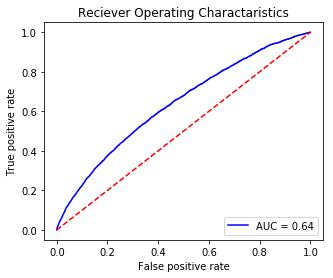

In [80]:
# Use roc metric
proba1 = mdl1.predict_proba(X_valid)[:,1]
fpr,tpr, threshold = roc_curve(y_valid,proba1)
auc_val1 = auc(fpr,tpr)

plt.figure(figsize=(5,4))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val1)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
print('roc_auc_score of train',roc_auc_score(y_train, mdl1.predict_proba(X_train)[:,1]))
print('roc_auc_score of test',roc_auc_score(y_valid, mdl1.predict_proba(X_valid)[:,1]))

In [91]:
pred_score1=gini_normalized(y_valid,mdl1.predict(X_valid))
proba_score1=gini_normalized(y_valid,proba1)
print ('Score of train:', gini_normalized(y_train,mdl1.predict_proba(X_train)[:,1]))
print ('Score of using predict function:', pred_score1)
print ('Score of using predict_proba function:', proba_score1)

Score of train: 0.268846164954
Score of using predict function: 0.000656531182069
Score of using predict_proba function: 0.273263917498


#### 3.5.2 Decision Tree

In [73]:
# Then use Decision Tree Classifier
mdl2 = DecisionTreeClassifier(max_depth=6)
mdl2.fit(X_train, y_train)

roc_train_mdl2 = roc_auc_score(y_train, mdl2.predict(X_train))
roc_test_mdl2 = roc_auc_score(y_valid, mdl2.predict(X_valid))
print(roc_train_base, roc_train_mdl2, roc_test_base, roc_test_mdl2)

0.5 0.501141507985 0.5 0.500434781424


roc_auc_score of train 0.614084107588
roc_auc_score of test 0.615969975736


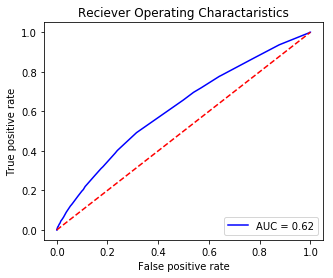

In [81]:
proba2 = mdl2.predict_proba(X_valid)[:,1]
fpr,tpr, threshold = roc_curve(y_valid,proba2)
auc_val2 = auc(fpr,tpr)

plt.figure(figsize=(5,4))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
print('roc_auc_score of train',roc_auc_score(y_train, mdl2.predict_proba(X_train)[:,1]))
print('roc_auc_score of test',roc_auc_score(y_valid, mdl2.predict_proba(X_valid)[:,1]))

In [90]:
pred_score2=gini_normalized(y_valid,mdl2.predict(X_valid))
proba_score2=gini_normalized(y_valid,proba2)
print ('Score of train:', gini_normalized(y_train,mdl2.predict_proba(X_train)[:,1]))
print ('Score of using predict function:', pred_score2)
print ('Score of using predict_proba function:', proba_score2)

Score of train: 0.228168215176
Score of using predict function: 0.000869562848235
Score of using predict_proba function: 0.231939951472


In [54]:
# Then I try to change some parameter of Decision Tree model and see the result
mdl3 = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=8,min_samples_split=3 )
mdl3.fit(X_train, y_train)

roc_train_mdl3 = roc_auc_score(y_train, mdl3.predict(X_train))
roc_test_mdl3 = roc_auc_score(y_valid, mdl3.predict(X_valid))
print(roc_train_base, roc_train_mdl3, roc_test_base, roc_test_mdl3)

0.5 0.5 0.5 0.5


Text(0.5,0,'False positive rate')

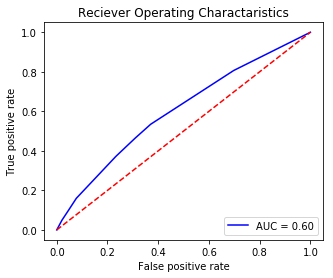

In [55]:
proba3 = mdl3.predict_proba(X_valid)[:,1]
fpr,tpr, threshold = roc_curve(y_valid,proba3)
auc_val3 = auc(fpr,tpr)

plt.figure(figsize=(5,4))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val3)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [93]:
pred_score3=gini_normalized(y_valid,mdl3.predict(X_valid))
proba_score3=gini_normalized(y_valid,proba3)
print ('Score of train:', gini_normalized(y_train,mdl3.predict_proba(X_train)[:,1]))
print ('Score of using predict function:', pred_score3)
print ('Score of using predict_proba function:', proba_score3)

Score of train: 0.189448199865
Score of using predict function: 0.0
Score of using predict_proba function: 0.205658418903


#### 3.5.3 Gradient Boosting

In [57]:
# Then I use Gradient Boosting model
mdl4 = GradientBoostingClassifier()
mdl4.fit(X_train, y_train)

roc_train_mdl4 = roc_auc_score(y_train, mdl4.predict(X_train))
roc_test_mdl4 = roc_auc_score(y_valid, mdl4.predict(X_valid))
print(roc_train_base, roc_train_mdl4, roc_test_base, roc_test_mdl4)

0.5 0.500657184416 0.5 0.500306470362


Text(0.5,0,'False positive rate')

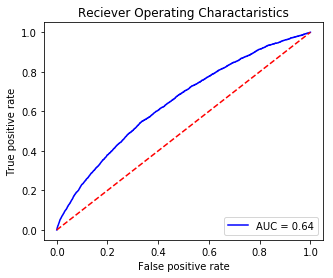

In [58]:
proba4 = mdl4.predict_proba(X_valid)[:,1]
fpr,tpr, threshold = roc_curve(y_valid,proba4)
auc_val4 = auc(fpr,tpr)

plt.figure(figsize=(5,4))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val4)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [94]:
pred_score4=gini_normalized(y_valid,mdl4.predict(X_valid))
proba_score4=gini_normalized(y_valid,proba4)
print ('Score of train:', gini_normalized(y_train,mdl4.predict_proba(X_train)[:,1]))
print ('Score of using predict function:', pred_score4)
print ('Score of using predict_proba function:', proba_score4)

Score of train: 0.292481435642
Score of using predict function: 0.000612940723148
Score of using predict_proba function: 0.287715389308


In [60]:
#Then I try to change max_depth and min_samples_split parameter to see the result
mdl5= GradientBoostingClassifier(criterion='friedman_mse', max_depth=5,
              min_samples_split=3)
mdl5.fit(X_train, y_train)

roc_train_mdl5 = roc_auc_score(y_train, mdl5.predict(X_train))
roc_test_mdl5 = roc_auc_score(y_valid, mdl5.predict(X_valid))
print(roc_train_base, roc_train_mdl5, roc_test_base, roc_test_mdl5)

0.5 0.502445592701 0.5 0.500728174648


roc_auc_score of train 0.670876337515
roc_auc_score of test 0.645311716246


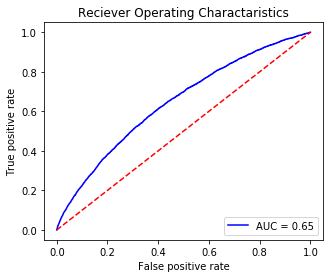

In [82]:
from sklearn.metrics import roc_curve, auc
proba5 = mdl5.predict_proba(X_valid)[:,1]
fpr,tpr, threshold = roc_curve(y_valid,proba5)
auc_val5 = auc(fpr,tpr)

plt.figure(figsize=(5,4))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val5)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
print('roc_auc_score of train',roc_auc_score(y_train, mdl5.predict_proba(X_train)[:,1]))
print('roc_auc_score of test',roc_auc_score(y_valid, mdl5.predict_proba(X_valid)[:,1]))

In [95]:
pred_score5=gini_normalized(y_valid,mdl5.predict(X_valid))
proba_score5=gini_normalized(y_valid,proba5)
print ('Score of train:', gini_normalized(y_train,mdl5.predict_proba(X_train)[:,1]))
print ('Score of using predict function:', pred_score5)
print ('Score of using predict_proba function:', proba_score5)

Score of train: 0.341752675029
Score of using predict function: 0.00145634929603
Score of using predict_proba function: 0.290623432492


In [64]:
# Next, I try to change max_leaf_nodes
mdl6 = GradientBoostingClassifier(max_depth=7, min_samples_split=3, max_leaf_nodes=10 )
mdl6.fit(X_train, y_train)

roc_train_mdl6 = roc_auc_score(y_train, mdl6.predict(X_train))
roc_test_mdl6 = roc_auc_score(y_valid, mdl6.predict(X_valid))
print(roc_train_base, roc_train_mdl6, roc_test_base, roc_test_mdl6)

0.5 0.500805594187 0.5 0.500173800253


Text(0.5,0,'False positive rate')

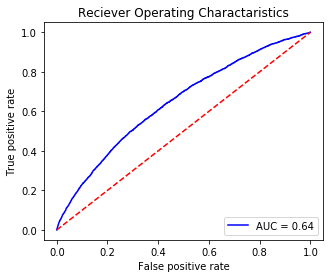

In [65]:
proba6 = mdl6.predict_proba(X_valid)[:,1]
fpr,tpr, threshold = roc_curve(y_valid,proba6)
auc_val6 = auc(fpr,tpr)

plt.figure(figsize=(5,4))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val6)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [96]:
pred_score6=gini_normalized(y_valid,mdl6.predict(X_valid))
proba_score6=gini_normalized(y_valid,proba6)
print ('Score of train:', gini_normalized(y_train,mdl6.predict_proba(X_train)[:,1]))
print ('Score of using predict function:', pred_score6)
print ('Score of using predict_proba function:', proba_score6)

Score of train: 0.296035789277
Score of using predict function: 0.000347600506277
Score of using predict_proba function: 0.289167298184


In [ ]:
# After compare the accuracy, it is obvious that predict_proba is better than predict function
# # Then choose the best one of each algorithm to make prediction

### 4. Make prediction and submission

#### 4.1 LogisticRegression

In [28]:
clf1 = LogisticRegression()
kfold=5
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.2, random_state=100)
pred1_test_all=0
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    pred1=clf1.fit(X_train, y_train)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    pred1_test = clf1.predict_proba(X_test)[:,1]
    pred1_test_all += pred1_test/kfold

[Fold 1/5]
[Fold 1/5 Prediciton:]
[Fold 2/5]
[Fold 2/5 Prediciton:]
[Fold 3/5]
[Fold 3/5 Prediciton:]
[Fold 4/5]
[Fold 4/5 Prediciton:]
[Fold 5/5]
[Fold 5/5 Prediciton:]


In [29]:
# Generate submission file
submit1 = pd.DataFrame({'id':test['id'],'target':pred1_test_all})
submit1.to_csv('lr.csv',index=False) 

#### 4.2 Decision Tree

In [22]:
# Use Decision Tree model to make prediction
clf2 = DecisionTreeClassifier(max_depth=6,min_samples_split=3)
kfold=5
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.2, random_state=100)
pred2_test_all=0
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
 
    # Train model
    pred2=clf2.fit(X_train, y_train)
    # Predict on test data
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    pred2_test = clf2.predict_proba(X_test)[:,1]
    pred2_test_all += pred2_test/kfold

[Fold 1/5]
[Fold 1/5 Prediciton:]
[Fold 2/5]
[Fold 2/5 Prediciton:]
[Fold 3/5]
[Fold 3/5 Prediciton:]
[Fold 4/5]
[Fold 4/5 Prediciton:]
[Fold 5/5]
[Fold 5/5 Prediciton:]


In [27]:
# Generate submission file
submit2 = pd.DataFrame({'id':test['id'],'target':pred2_test_all})
submit2.head()
submit2.to_csv('cart.csv',index=False) 

#### 4.3 Gradient Boosting

In [33]:
# Use Gradient Boosting model to make prediction
clf3=GradientBoostingClassifier(criterion='friedman_mse', max_depth=5,
              min_samples_split=3)
kfold=5
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.2, random_state=100)
pred3_test_all=0
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    pred2=clf3.fit(X_train, y_train)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    pred3_test = clf3.predict_proba(X_test)[:,1]
    pred3_test_all += pred3_test/kfold

[Fold 1/5]
[Fold 1/5 Prediciton:]
[Fold 2/5]
[Fold 2/5 Prediciton:]
[Fold 3/5]
[Fold 3/5 Prediciton:]
[Fold 4/5]
[Fold 4/5 Prediciton:]
[Fold 5/5]
[Fold 5/5 Prediciton:]


In [35]:
# Generate submission file
submit3 = pd.DataFrame({'id':test['id'],'target':pred3_test_all})
submit3.to_csv('gb.csv',index=False)

#### 4.4 Score on Kaggle

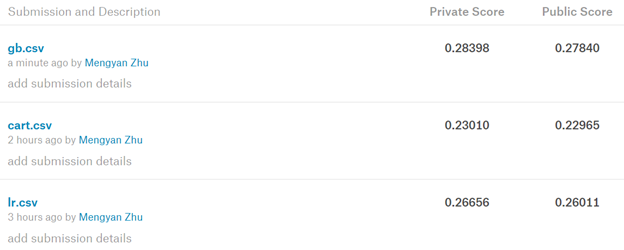